© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# 🔠 Homework 9 — Softmax Regression on Letter Recognition Dataset

The goal of this task is to implement the **softmax regression** model and apply it to the [Letter Recognition Dataset](https://archive.ics.uci.edu/ml/datasets/Letter+Recognition).


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

## 📚 Softmax Regression

The softmax regression model outputs a probability distribution over $K$ classes using the **softmax activation function**:

$$
h(x) = \text{softmax}(W^\top x + B) \in \mathbb{R}^K
$$

Component-wise, this is:

$$
h_k(x) = \frac{\exp(w_k^\top x + b_k)}{\sum_{j=1}^K \exp(w_j^\top x + b_j)}, \quad 1 \leq k \leq K
$$

Where:
- $K$: number of classes 
- $d$: number of features 
- $W \in \mathbb{R}^{d \times K}$: weight matrix
- $B \in \mathbb{R}^{K}$: bias vector


The model is trained by minimizing the **cross-entropy loss**. Assuming labels are one-hot encoded ($y \in \{0,1\}^K$), the loss is defined as:

$$
\mathcal{L}(y, \hat{y}) = - \sum_{k=1}^K y[k] \log(\hat{y}[k])
$$


### 💡 Gradients Calculation

- The softmax derivative is given by:

$$
\dfrac{\partial \text{softmax}(z)_k}{\partial z_i} = \text{softmax}(z)_k (\delta_{ki} - \text{softmax}(z)_i), \quad \delta_{ik}=1\text{ if }i=k\text{ and }0\text{ otherwise.}
$$

- Denote $z_j(x) = \langle w_j,x \rangle + b_j$ for all $j=1,\dots, K$. The derivative of the decision function is thus:

$$
\dfrac{\partial h_k(x)}{\partial w_i} =  \dfrac{\partial \text{softmax}(z(x))_k}{\partial z_i(x)} \dfrac{\partial z_i(x)}{\partial w_i} = h_k(x) (\delta_{ki} - h_i(x))\cdot x
$$

- Noticing that the one-hot encoded labels satisfy $y[i] = \delta_{ci}$, where $c$ is the class number, we can compute derivative of the loss on a single point $\mathcal{L}$ (slight abuse of notation) as follows:

$$
\dfrac{\partial \mathcal{L}(x)}{\partial w_i} = \sum_j \dfrac{\partial \mathcal{L}(x)}{\partial h_j(x)} \dfrac{\partial h_j(x)}{\partial w_i}
= -\sum_j \dfrac{y[j]}{h_j(x)} h_j(x) (\delta_{ji} - h_i(x))\cdot x = (h_i(x) - y[i])\cdot x \Rightarrow \dfrac{\partial \mathcal{L}(x)}{\partial W} = x \cdot (h(x) - y)^\top \in \mathbb{R}^{d\times K}
$$

Summing this (and analogous computations for biases) over the whole dataset we get the following usual matrix expressions for the gradients

 - **Weight gradient**:
   $$
   \nabla_W \mathcal{L} = \frac{1}{N} X^T (h(X) - Y)
   $$

 - **Bias gradient**:
   $$
   \nabla_B \mathcal{L} = \frac{1}{N} \mathbb{1}^T (h(X) - Y)
   $$

We implement this in the following cell. 

In [2]:
from courselib.models.base import TrainableModel

def softmax(x):
    """
    Compute the softmax of a vector or matrix.
    
    Parameters:
        x: Input array (can be 1D or 2D)
        
    Returns:
        Softmax probabilities (same shape as input)
    """
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # for numerical stability
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

class SoftmaxRegression(TrainableModel):
    """
    Softmax regression model.

    Parameters:
        - w: Initial weights (array-like)
        - b: Initial bias (scalar)
        - optimizer: Optimizer object (e.g., GDOptimizer)
        - penalty: One of {"none", "ridge", "lasso"}
        - alpha: Regularization strength (default: 0.0)
    """
    
    def __init__(self, w, b, optimizer, penalty="none", lam=0.0):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)   # shape (d, K)
        self.b = np.array(b, dtype=float).reshape(1, -1)  # shape (1, K)
        self.penalty = penalty
        self.lam = float(lam)

    def loss_grad(self, X, y):
        residual = self.decision_function(X) - y
        grad_w = X.T @ residual / len(X)
        grad_b = np.mean(residual, axis=0, keepdims=True)

        # Add regularization if specified
        if self.penalty == "ridge":
            grad_w += self.alpha * self.w
        elif self.penalty == "lasso":
            grad_w += self.alpha * np.sign(self.w)

        return {"w": grad_w, "b": grad_b}
    
    def decision_function(self, X):
        return softmax(X @ self.w + self.b)
    
    def _get_params(self):
        """
        Return model parameters as a dict for the optimizer.
        """
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        return np.argmax(self.decision_function(X), axis=-1)

### OvR Multiclass Logistic Regression

For comparison, we include an impelementation of one-vs-rest logistic regression model, as defined in the lecture.

In [3]:
from courselib.models.glm import sigmoid

class MulticlassLogisticRegression(TrainableModel):
    """
    Multiclass logistic regression model with optional regularization.
    Labels are expected to be one-hot encoded.

    Parameters:
        - w: Initial weights (array-like)
        - b: Initial bias (scalar)
        - optimizer: Optimizer object (e.g., GDOptimizer)
        - penalty: One of {"none", "ridge", "lasso"}
        - alpha: Regularization strength (default: 0.0)
    """
    
    def __init__(self, w, b, optimizer, penalty="none", lam=0.0):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)   # shape (d, K)
        self.b = np.array(b, dtype=float).reshape(1, -1)  # shape (1, K)
        self.penalty = penalty
        self.lam = float(lam)

    def loss_grad(self, X, y):
        residual = self.decision_function(X) - y
        grad_w = X.T @ residual / len(X)
        grad_b = np.mean(residual, axis=0, keepdims=True)

        # Add regularization if specified
        if self.penalty == "ridge":
            grad_w += self.alpha * self.w
        elif self.penalty == "lasso":
            grad_w += self.alpha * np.sign(self.w)

        return {"w": grad_w, "b": grad_b}
    
    def decision_function(self, X):
        return sigmoid(X @ self.w + self.b)
    
    def _get_params(self):
        """
        Return model parameters as a dict for the optimizer.
        """
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        return np.argmax(self.decision_function(X), axis=-1)
    

### Load the Data

We load the [Letter Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Letter+Recognition) from the UCI repository. The dataset contains 16 numerical features derived from images of capital letters of the English alphabet. The task is to classify the inputs into 26 classes, each corresponding to one of the alphabet letters.

In [4]:
from courselib.utils.loaders import load_or_download_csv

file_name = 'letter-recognition.data'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
column_names = ['letter','x-box','y-box','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar',
               'x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']


df = load_or_download_csv(file_name, url, column_names)

Loading from local `letter-recognition.data`...


In [5]:
df

,letter,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


### Train-Test Split

In [6]:
from courselib.utils.splits import train_test_split

training_data_fraction = .8

X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df, training_data_fraction=0.8, class_column_name='letter', return_numpy=True)

### Labels Encoding

In [7]:
labels = sorted(np.unique(Y))
labels 

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [8]:
from courselib.utils.preprocessing import labels_encoding

Y = labels_encoding(Y, labels=labels, pos_value=1, neg_value=0) 
Y_train = labels_encoding(Y_train, labels=labels, pos_value=1, neg_value=0) 
Y_test = labels_encoding(Y_test, labels=labels, pos_value=1, neg_value=0)

### Train and Evaluate

In [9]:
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import accuracy, mean_squared_error, cross_entropy

K = Y_train.shape[1]  

W = np.zeros((X.shape[1],K))
b = [1]*K

metrics_dict = {
    "accuracy": accuracy,
    "MSE": mean_squared_error,
    "CE": cross_entropy
}

optimizer = GDOptimizer(learning_rate=1e-2)
softmax_reg = SoftmaxRegression(W,b, optimizer)
metrics_history_softmax = softmax_reg.fit(X_train, Y_train, num_epochs=5000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

The final train accuracy: 74.0%
Test accuracy: 74.9%


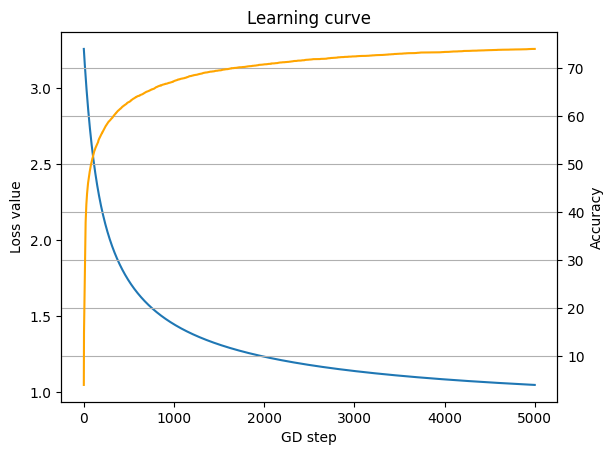

In [10]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history_softmax['CE'])), metrics_history_softmax['CE'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_softmax['accuracy'])), metrics_history_softmax['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('GD step')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(metrics_history_softmax['accuracy'][-1],1)}%')
print(f'Test accuracy: {round(accuracy(softmax_reg.decision_function(X_test), Y_test),1)}%')

The final accuracy of **~75%** is still far from perfect. However, it is also much better than random guess for a problem with 26 classes, which would give ~4% accuracy. 

## Models Comparison

For comparison, we also train the OvR logistic regression model and a multiclass least squares classification model.

In [11]:
from courselib.models.linear_models import LinearMulticlassClassification

metrics_dict = {
    "accuracy": accuracy,
    "MSE": mean_squared_error,
}

logreg = MulticlassLogisticRegression(W,b, optimizer)
metrics_history_logreg = logreg.fit(X_train, Y_train, num_epochs=5000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

optimizer = GDOptimizer(learning_rate=1e-3) # larger lrs result in overflow
linreg = LinearMulticlassClassification(W,b, optimizer)
metrics_history_linreg = linreg.fit(X_train, Y_train, num_epochs=5000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

Softmax Regression:
The final train accuracy: 74.0%
Test accuracy: 74.9%
OvR Logistic Regression:
The final train accuracy: 69.6%
Test accuracy: 70.2%
OLS Regression:
The final train accuracy: 55.8%
Test accuracy: 55.9%


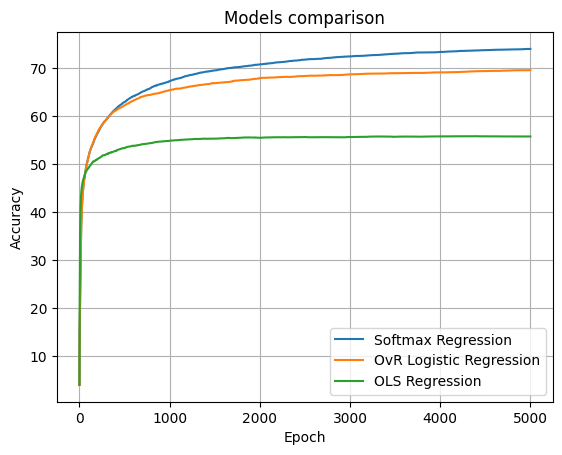

In [12]:
fig, ax = plt.subplots()

for metrics_history, model, name in zip([metrics_history_softmax, metrics_history_logreg, metrics_history_linreg],
                                        [softmax_reg, logreg, linreg],
                                        ['Softmax Regression', 'OvR Logistic Regression', 'OLS Regression']):

    ax.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], label = name)
    

    print(f'{name}:')
    print(f'The final train accuracy: {round(metrics_history['accuracy'][-1],1)}%')
    print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), Y_test),1)}%')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Models comparison')
plt.legend()
plt.grid()

We can see that the softmax regression model outperforms the other two!

## Confusion Matrix

We define a new tool for diagnosing a multiclass model's performance: the **confusion matrix**. This matrix displays how often the model predicts each class compared to the true labels. 

In [13]:
def confusion_matrix(y_true, y_pred, num_classes=None):

    if num_classes is None:
        num_classes = y_true.shape[-1]

    true_labels = np.argmax(y_true, axis=-1)
    pred_labels = np.argmax(y_pred, axis=-1)

    cm = np.zeros((num_classes, num_classes), dtype=int)

    for t, p in zip(true_labels, pred_labels):
        cm[t, p] += 1

    return cm

def plot_confusion_matrix(cm, cmap="Blues", figsize=(6, 5), class_names=None, title="Confusion Matrix"):
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    n_classes = cm.shape[0]

    if class_names is None:
        class_names = np.arange(n_classes)

    # Tick labels
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
            xticklabels=class_names,
            yticklabels=class_names,
           ylabel="True label",
           xlabel="Predicted label",
           title=title)

    # Rotate x-tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annotate each cell
    thresh = cm.max() / 2.0
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(
                j, i,
                format(cm[i, j], 'd'),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=11,
            )

    plt.tight_layout()
    plt.show()

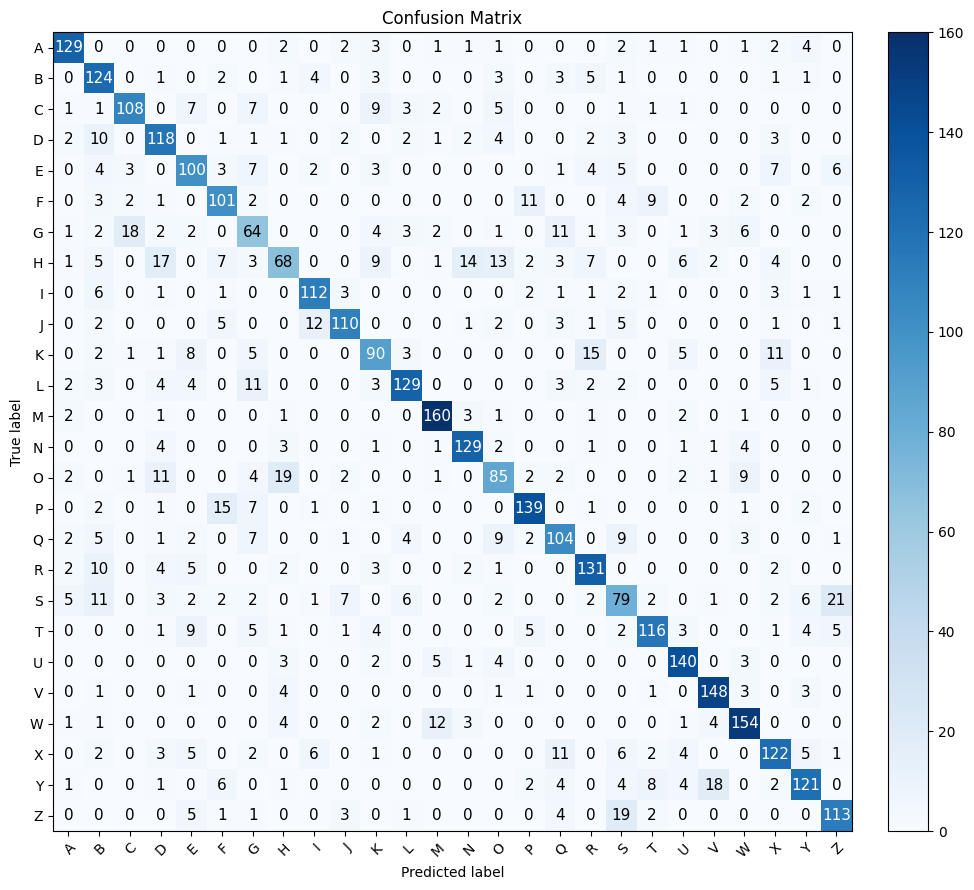

In [14]:
plot_confusion_matrix(confusion_matrix(Y_test, softmax_reg.decision_function(X_test)), 
                      class_names=labels,
                      figsize=(10,9))

We see that our softmax regression model often confuses G with C, O with H, and S with Z. 